# II. Model Development
Date: 28/01/2020

In this notebook the model selection procedure and assessment of the selected model is performed.

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import *
import matplotlib.pyplot as plt
import seaborn as sn

# For preprocessing:
from sklearn.preprocessing import StandardScaler

# For Feature selection:
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import make_scorer, precision_score, recall_score, fbeta_score, balanced_accuracy_score

# Models:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
import xgboost as xgb
from sklearn import svm

from sklearn.utils import class_weight

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from collections import Counter

%matplotlib inline

/home/eric/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/home/eric/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/eric/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions 

## 0. Loading the train and test data

We load the train and test datasets that we have previously preprocessed:

In [2]:
train = pd.read_csv('output/train.csv',
                   parse_dates = ['ANNDT_ACT','FPEDATS','STATPERS'])
test = pd.read_csv('output/test.csv',
                  parse_dates = ['ANNDT_ACT','FPEDATS','STATPERS'])

In [3]:
print('The dimensions of the train set are: %s' % str(train.shape))
print('The dimensions of the test set are: %s' % str(test.shape))

print('Interval of time covered by TRAIN: %s to %s' % (min(train.FPEDATS),max(train.FPEDATS)))
print('Interval of time covered by TEST: %s to %s' % (min(test.FPEDATS),max(test.FPEDATS)))

The dimensions of the train set are: (1609, 47)
The dimensions of the test set are: (459, 47)
Interval of time covered by TRAIN: 2000-01-31 00:00:00 to 2014-12-31 00:00:00
Interval of time covered by TEST: 2015-01-31 00:00:00 to 2018-12-31 00:00:00


In [4]:
# Loading the ICLINK linking table:
iclink = pd.read_csv('data/iclink.csv')

test = test.merge(iclink[['TICKER','MG','IG']], on='TICKER', how='left')
train = train.merge(iclink[['TICKER','MG','IG']], on='TICKER', how='left')

In [4]:
# Sort dataset by date and TICKER:
train.sort_values(['FPEDATS','TICKER'], inplace=True)
train.reset_index(drop=True, inplace=True)

test.sort_values(['FPEDATS','TICKER'], inplace=True)
test.reset_index(drop=True, inplace=True)

Keep only the relevant variables as identified in the variable selection section:

In [5]:
target = 'FEC'
features = ['size_pct',
            'FECq1',
            'AFD1','AFD2', 'AFD3',
            'tbill1Y','ppi_mach','cs_pub','cs_pri','unemp_excess',
            'ndelay',
            'capital_ratio','inv_turn','debt_ebitda','quick_ratio','roa','evm']

In [6]:
# Save the descriptive statistics for the report:
desc_stat = train[features].describe()
desc_stat =desc_stat.transpose(copy=True)
desc_stat.to_excel('output/descriptive_stat.xlsx')

In [7]:
# Split the data between X and Y:
y_train = train[target]
X_train = train[features]

y_test = test[target]
X_test = test[features]

# Print:
print('X train shape : %s' % str(X_train.shape))
print('X test shape : %s' % str(X_test.shape))

X train shape : (1609, 17)
X test shape : (459, 17)


In [8]:
print(train.TICKER.nunique())
print(test.TICKER.nunique())

47
33


Scale the different features:

In [9]:
# Scale the data:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_sc, columns=X_train.columns)

And keep labels of firms to CV taking into account groups:

In [10]:
firms = train['TICKER']

## 1. Defining Performance Metrics and a Baseline Classifier

First I define the performance metric:

In [11]:
# Precision and recall for Surprises macro averaged:
pre_score = make_scorer(precision_score, average = 'macro', labels=[1,3])
rec_score = make_scorer(recall_score, average = 'macro', labels=[1,3])

# Create a scorer for beta=0.5; and micro and macro-average:
f_macro = make_scorer(fbeta_score, beta=0.5, average='macro')
f_micro = make_scorer(fbeta_score, beta=0.5, average='micro')
balanced_acc = make_scorer(balanced_accuracy_score)

metrics = {'Pre_sur_macro': pre_score,
           'Rec_sur_macro': rec_score,
           'F_.5_macro': f_macro,
           'F_.5_micro': f_micro,
           'Bal_Acc': balanced_acc}

Define a results table function:

In [12]:
def results_table(cv_res):
    # Create table with the results:
    res = pd.DataFrame({'Fold':['Fold1','Fold2','Fold3','Fold4','Fold5'],
                   'Precision Test Score (Surprises)': cv_res['test_Pre_sur_macro'],
                   'Recall Test Score (Surprises)': cv_res['test_Rec_sur_macro'],
                   'Precision Train Score (Surprises)': cv_res['train_Pre_sur_macro'],
                   'Recall Train Score (Surprises)': cv_res['train_Rec_sur_macro'],
                   'Train Score: F .5 Macro': cv_res['train_F_.5_macro'],
                   'Test Score: F .5 Macro': cv_res['test_F_.5_macro'],
                   'Train Score: F .5 Micro': cv_res['train_F_.5_micro'],
                   'Test Score: F .5 Micro': cv_res['test_F_.5_micro'],
                   'Balanced Accuracy (test)': cv_res['test_Bal_Acc']})
    
    # Compute the average across folds:
    avg = pd.DataFrame({'Fold':['Average'],
                   'Precision Test Score (Surprises)': np.mean(cv_res['test_Pre_sur_macro']),
                   'Recall Test Score (Surprises)': np.mean(cv_res['test_Rec_sur_macro']),
                   'Precision Train Score (Surprises)': np.mean(cv_res['train_Pre_sur_macro']),
                   'Recall Train Score (Surprises)': np.mean(cv_res['train_Rec_sur_macro']),
                   'Train Score: F .5 Macro': np.mean(cv_res['train_F_.5_macro']),
                   'Test Score: F .5 Macro': np.mean(cv_res['test_F_.5_macro']),
                   'Train Score: F .5 Micro': np.mean(cv_res['train_F_.5_micro']),
                   'Test Score: F .5 Micro': np.mean(cv_res['test_F_.5_micro']),
                   'Balanced Accuracy (test)': np.mean(cv_res['test_Bal_Acc'])})
    
    # Add average:
    res = np.round(res.append(avg),3)
    
    return res, avg

### 1.1. Baseline model

First we establish a baseline model, always predict the majority class, which in our case is: no surprise.

In [13]:
# Define the model:
baseline = DummyClassifier(strategy='most_frequent')

# Cross validate the model:
cv_res0 = cross_validate(baseline,
                        X_train, y_train,
                        groups = firms,
                        cv = TimeSeriesSplit(n_splits=5),
                        scoring = metrics,
                        return_train_score=True,
                        n_jobs = -1)


# CV Results:
res0, avg0 = results_table(cv_res0)
res0

,Fold,Precision Test Score (Surprises),Recall Test Score (Surprises),Precision Train Score (Surprises),Recall Train Score (Surprises),Train Score: F .5 Macro,Test Score: F .5 Macro,Train Score: F .5 Micro,Test Score: F .5 Micro,Balanced Accuracy (test)
0,Fold1,0.0,0.0,0.0,0.0,0.295,0.289,0.859,0.840,0.333
1,Fold2,0.0,0.0,0.0,0.0,0.292,0.226,0.849,0.627,0.333
2,Fold3,0.0,0.0,0.0,0.0,0.271,0.178,0.775,0.478,0.333
3,Fold4,0.0,0.0,0.0,0.0,0.248,0.174,0.701,0.466,0.333
4,Fold5,0.0,0.0,0.0,0.0,0.234,0.238,0.654,0.668,0.333
0,Average,0.0,0.0,0.0,0.0,0.268,0.221,0.768,0.616,0.333


## 2. Model Selection (without oversampling)

Here we are going to do model selection without oversampling techniques to not lose the time dimension.

The CV is done in 5-folds, the split taking into account time dimension and taking into account groups.

(Here we use class weights to account for class imbalance)

### 2.1. Multinomial Logistic Regression

Here I try a linear method, a multinomal logístic regression:


In [14]:
# Define the model:
logreg = LogisticRegression(solver = 'lbfgs',
                            multi_class = 'multinomial',
                            class_weight = 'balanced',
                            max_iter = 1000)

# Cross validate the model:
cv_res1 = cross_validate(logreg,
                        X_train, y_train,
                        groups = firms,
                        cv = TimeSeriesSplit(n_splits=5),
                        scoring = metrics,
                        return_train_score=True,
                        n_jobs = -1)

# CV Results:
res1, avg1 = results_table(cv_res1)
res1

,Fold,Precision Test Score (Surprises),Recall Test Score (Surprises),Precision Train Score (Surprises),Recall Train Score (Surprises),Train Score: F .5 Macro,Test Score: F .5 Macro,Train Score: F .5 Micro,Test Score: F .5 Micro,Balanced Accuracy (test)
0,Fold1,0.108,0.393,0.321,0.842,0.542,0.328,0.703,0.410,0.402
1,Fold2,0.253,0.352,0.278,0.652,0.512,0.400,0.713,0.481,0.427
2,Fold3,0.313,0.557,0.327,0.613,0.532,0.352,0.677,0.425,0.413
3,Fold4,0.372,0.315,0.391,0.595,0.564,0.436,0.672,0.481,0.434
4,Fold5,0.388,0.286,0.389,0.521,0.551,0.480,0.651,0.649,0.463
0,Average,0.287,0.381,0.341,0.645,0.540,0.399,0.683,0.490,0.428


### 2.2. Balanced Bagging Classifier

Here I try another tree ensemble methodology, a Balanced Bagging Classifier. This Bagging classifier does an additional step rebalancing the training set using a random undersampler.

In [16]:
# Define the model:
balancedbagging = BalancedBaggingClassifier(random_state=7777)

# Cross validate the model:
cv_res2 = cross_validate(balancedbagging,
                        X_train, y_train,
                        groups = firms,
                        cv = TimeSeriesSplit(n_splits=5),
                        scoring = metrics,
                        return_train_score=True,
                        n_jobs = -1)

# CV Results:
res2, avg2 = results_table(cv_res2)
res2

,Fold,Precision Test Score (Surprises),Recall Test Score (Surprises),Precision Train Score (Surprises),Recall Train Score (Surprises),Train Score: F .5 Macro,Test Score: F .5 Macro,Train Score: F .5 Micro,Test Score: F .5 Micro,Balanced Accuracy (test)
0,Fold1,0.198,0.392,0.371,0.947,0.592,0.433,0.770,0.664,0.500
1,Fold2,0.158,0.180,0.448,0.987,0.651,0.325,0.814,0.496,0.356
2,Fold3,0.323,0.518,0.587,0.959,0.742,0.362,0.847,0.418,0.408
3,Fold4,0.373,0.410,0.654,0.952,0.780,0.470,0.849,0.504,0.478
4,Fold5,0.269,0.375,0.723,0.955,0.823,0.427,0.870,0.537,0.451
0,Average,0.264,0.375,0.556,0.960,0.717,0.403,0.830,0.524,0.439


### 2.3. Random Forest Classifier

Here I try a tree ensemble, a Random Forest:

In [17]:
# Define the model:
randomforest = RandomForestClassifier(n_jobs=-1,
                                      random_state = 7777,
                                      max_features = 'sqrt',
                                      bootstrap = True,
                                      criterion = 'entropy',
                                      class_weight = 'balanced',
                                      oob_score = False)

# Cross validate the model:
cv_res3 = cross_validate(randomforest,
                        X_train, y_train,
                        groups = firms,
                        cv = TimeSeriesSplit(n_splits=5),
                        scoring = metrics,
                        return_train_score=True,
                        n_jobs = -1)

# CV Results:
res3, avg3 = results_table(cv_res3)
res3

,Fold,Precision Test Score (Surprises),Recall Test Score (Surprises),Precision Train Score (Surprises),Recall Train Score (Surprises),Train Score: F .5 Macro,Test Score: F .5 Macro,Train Score: F .5 Micro,Test Score: F .5 Micro,Balanced Accuracy (test)
0,Fold1,0.250,0.043,1.0,1.0,1.0,0.377,1.0,0.843,0.361
1,Fold2,0.000,0.000,1.0,1.0,1.0,0.227,1.0,0.627,0.333
2,Fold3,0.325,0.211,1.0,1.0,1.0,0.394,1.0,0.575,0.435
3,Fold4,0.485,0.196,1.0,1.0,1.0,0.446,1.0,0.530,0.434
4,Fold5,0.400,0.084,1.0,1.0,1.0,0.391,1.0,0.668,0.375
0,Average,0.292,0.107,1.0,1.0,1.0,0.367,1.0,0.649,0.388


### 2.4. XGBoost

Here I try an XGBoost model:

In [18]:
# Compute class weights:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
#print(class_weights)

In [19]:
# Define the model:
xgboost = xgb.XGBClassifier(booster = 'gbtree',
                            objective = 'mlogloss',
                            class_weight = class_weights)

# Cross validate the model:
cv_res4 = cross_validate(xgboost,
                        X_train, y_train,
                        groups = firms,
                        cv = TimeSeriesSplit(n_splits=5),
                        scoring = metrics,
                        return_train_score=True,
                        n_jobs = -1)

# CV Results:
res4, avg4 = results_table(cv_res4)
res4

,Fold,Precision Test Score (Surprises),Recall Test Score (Surprises),Precision Train Score (Surprises),Recall Train Score (Surprises),Train Score: F .5 Macro,Test Score: F .5 Macro,Train Score: F .5 Micro,Test Score: F .5 Micro,Balanced Accuracy (test)
0,Fold1,0.325,0.180,1.000,1.000,1.000,0.482,1.000,0.828,0.437
1,Fold2,0.167,0.030,1.000,0.862,0.972,0.283,0.980,0.604,0.335
2,Fold3,0.237,0.278,0.965,0.714,0.909,0.342,0.937,0.496,0.391
3,Fold4,0.426,0.187,0.891,0.648,0.840,0.414,0.884,0.522,0.426
4,Fold5,0.350,0.122,0.856,0.614,0.806,0.417,0.849,0.672,0.394
0,Average,0.301,0.159,0.942,0.767,0.905,0.388,0.930,0.625,0.397


### 2.5. Linear SVM

Here, I consider a linear SVM model:

In [20]:
# Define the model:
ovr_svm = OneVsRestClassifier(svm.LinearSVC())

# Cross validate the model:
cv_res5 = cross_validate(ovr_svm,
                        X_train, y_train,
                        groups = firms,
                        cv = TimeSeriesSplit(n_splits=5),
                        scoring = metrics,
                        return_train_score=True,
                        n_jobs = -1)

# CV Results:
res5, avg5 = results_table(cv_res5)
res5

,Fold,Precision Test Score (Surprises),Recall Test Score (Surprises),Precision Train Score (Surprises),Recall Train Score (Surprises),Train Score: F .5 Macro,Test Score: F .5 Macro,Train Score: F .5 Micro,Test Score: F .5 Micro,Balanced Accuracy (test)
0,Fold1,0.176,0.237,0.321,0.237,0.502,0.421,0.877,0.750,0.441
1,Fold2,0.417,0.060,0.275,0.131,0.449,0.337,0.860,0.612,0.352
2,Fold3,0.273,0.423,0.307,0.201,0.469,0.435,0.806,0.627,0.506
3,Fold4,0.613,0.110,0.605,0.265,0.505,0.363,0.763,0.515,0.399
4,Fold5,0.433,0.065,0.526,0.237,0.497,0.377,0.708,0.675,0.371
0,Average,0.383,0.179,0.407,0.214,0.484,0.387,0.803,0.636,0.414


### 2.6. Model Summary

Here I do a model summary to decide which model to take:

In [21]:
# Create model summary:
model_summary = avg0.append([avg1,avg2,avg3,avg4,avg5])
model_summary.rename({'Fold':'Model'}, axis=1, inplace=True)
model_summary['Model'] = ['Baseline','Logisitc Regression', 'Bagging Classifier', 'Random Forest', 'XGBoost', 'OVR SVM']

In [22]:
np.round(model_summary,2)

,Model,Precision Test Score (Surprises),Recall Test Score (Surprises),Precision Train Score (Surprises),Recall Train Score (Surprises),Train Score: F .5 Macro,Test Score: F .5 Macro,Train Score: F .5 Micro,Test Score: F .5 Micro,Balanced Accuracy (test)
0,Baseline,0.00,0.00,0.00,0.00,0.27,0.22,0.77,0.62,0.33
0,Logisitc Regression,0.29,0.38,0.34,0.64,0.54,0.40,0.68,0.49,0.43
0,Bagging Classifier,0.26,0.38,0.56,0.96,0.72,0.40,0.83,0.52,0.44
0,Random Forest,0.29,0.11,1.00,1.00,1.00,0.37,1.00,0.65,0.39
0,XGBoost,0.30,0.16,0.94,0.77,0.91,0.39,0.93,0.62,0.40
0,OVR SVM,0.38,0.18,0.41,0.21,0.48,0.39,0.80,0.64,0.41


## 3. Model Performance Evaluation

Here we have selected the following model:

In [23]:
# Selected model:
model = logreg

And fit the model to the training data and fit to the test data:

In [24]:
# Fit the model to the training data:
model.fit(X_train,y_train)

# Make predictions for test data:
y_pred = model.predict(X_test)

And the model results are:

In [25]:
# Precision, recall and F1 score:
print(classification_report(y_test, y_pred,
                            labels=[1, 2, 3],
                            target_names = ['Negative Surprise', 'No Surprise', 'Positive Surprise']))

                   precision    recall  f1-score   support

Negative Surprise       0.06      0.13      0.09        53
      No Surprise       0.85      0.43      0.57       344
Positive Surprise       0.22      0.61      0.32        62

         accuracy                           0.42       459
        macro avg       0.38      0.39      0.33       459
     weighted avg       0.67      0.42      0.48       459



In [26]:
print(precision_score(y_test, y_pred, average = 'macro'))
print(precision_score(y_test, y_pred, average = 'micro'))
print(recall_score(y_test, y_pred, average = 'macro'))
print(recall_score(y_test, y_pred, average = 'micro'))

0.3768614015707039
0.4226579520697168
0.3927060774627619
0.4226579520697168


In [27]:
beta = 0.5

# Compute beta scores:
f_scores = np.round([balanced_accuracy_score(y_test, y_pred),fbeta_score(y_test, y_pred, beta=beta , average='macro'),fbeta_score(y_test, y_pred, beta=beta , average='micro'), fbeta_score(y_test, y_pred, beta=beta , average='weighted')],3)
f = pd.DataFrame({'Average Type': ['Balanced Accuracy','F .5 Macro', 'F .5 Micro', 'F .5 Weighted',], 'Score': f_scores})
f

,Average Type,Score
0,Balanced Accuracy,0.393
1,F .5 Macro,0.345
2,F .5 Micro,0.423
3,F .5 Weighted,0.575


In [28]:
# Print the Fbeta score per class:
fbeta_score(y_test, y_pred, beta=beta, average=None)

array([0.07042254, 0.71087786, 0.25333333])

And plot the confusion matrix:

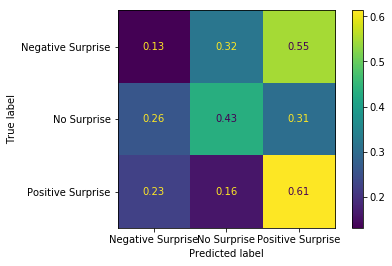

In [30]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model,X_test,y_true = y_test,
                      labels = np.array([1,2,3]),
                      display_labels = np.array(['Negative Surprise', 'No Surprise', 'Positive Surprise']),
                      normalize = 'true');

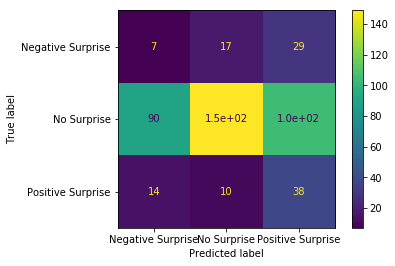

In [31]:
plot_confusion_matrix(model,X_test,y_true = y_test,
                      labels = np.array([1,2,3]),
                      display_labels = np.array(['Negative Surprise', 'No Surprise', 'Positive Surprise']));

And the variable importance:

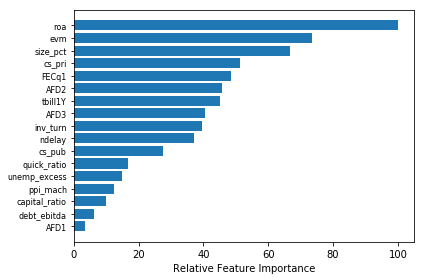

In [32]:
# Compute the relative feature importance
feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# Plot the realtive feature importance:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.barh(pos, feature_importance[sorted_idx], align='center')
ax.set_yticks(pos)
ax.set_yticklabels(np.array(X_train.columns)[sorted_idx], fontsize=8)
ax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

## 4. Save signals

In [33]:
# Create signals df:
signals = test[['TICKER','FPEDATS','ANNDT_ACT','ACTUAL','FEC']]

# Add the predictions
signals['FEC_pred'] = y_pred

/home/eric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [35]:
#signals[['FEC','FEC_pred']].hist(figsize=(5,5));

In [36]:
# Save signals:
signals.to_csv('output/signals.csv',index=False)